Transfer Learning is a powerful technique.

**The premise is: find a well-performing existing model and apply it to one's own problem.**

The two main benefits to using Transfer Learning are as follows:

1. Can leverage an existing model (a NN architecture) proven to work on problems similar to one's own.
2. Can leverage a working model which has already learned patterns on similar data to one's own. This often results in achieving great results with less custom data.

Both research and practice support the use of Transfer Learning.

Good to ask the question, **"Does a pre-trained model exist for the undertaken problem ?"** at the start of every DL problem.

### 0. Getting Setup

In [1]:
# Importing the required modules for this section
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine # needed to avoid rewriting the downloaded data prep and model training code

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get data

In [3]:
import os
import zipfile
from pathlib import Path
import requests

# data folder path setup
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder already exists, then skip downloading the data. Otherwise, create it & download and prepare the data in it.
if image_path.is_dir():
    print(f"{image_path} folder exists. Skipping download.")
else:
    print("Couldn't find the image data folder thus, creating one.")
    image_path.mkdir(parents = True, exist_ok = True)

    # Download food image data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading the data...")
        f.write(request.content)
        print("Downloaded.")

    # Unzipping the data zip file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
        print("Unzipping the downloaded zip file of data...")
        zip_file.extractall(image_path)
        print("Unzipped.")

    # Remove the .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi folder exists. Skipping download.


In [4]:
# Setup train and test directories' paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and DataLoaders

Will be using **data_setup.py** script from going_modular module to prepare and setup the DataLoaders.

However, since will be using a pre-trained model from **torchvision.models**, a specific transform need to be prepared for the images first.

#### 2.1 Creating a transform for torchvision.models (manual creation)

**The custom data going into the pre-trained model, while using it, should be prepared in the same way as tthe original training data that wnet in there.**

Hwever, the input images sizes may differ according to different pre-trained models.

In [5]:
# Creating the transforms pipeline manually (reqd for torchvision version < 0.13 to use pretrained models)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (or model dependent inputimage sizes)
    transforms.ToTensor(), # 2. Image values in the range [0, 1]
    transforms.Normalize(mean = [0.485, 0.456, 0.406], # 3. Mean of specified values across each color channel
                         std = [0.229, 0.224, 0.225]) # 4. Standard deviation values across each color channel
])

# These transforms are manually created so, they are customizable.
# Thus, data augmentation techniques can be included if wanted to in the transforms pipeline.

In [6]:
# Create training and testing DataLoaders and get a list of class_names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir,
                                                                               manual_transforms, # Resize, [0, 1] range & normalize
                                                                               batch_size=32) # mini-batches of size 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a1ae056450>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 Creating a transform for torchvision.models (auto creation)

In [7]:
# Getting a set of pre-trained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT means the best available weights from pre-training on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the transforms (associated) used to create/traain the pretrained weights over the ImageNet dataset
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Create training and testing DataLoaders and get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir,
                                                                              auto_transforms, # Same transformations as on pretraining data
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a1ae09c690>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model

#### 3.1 Which pretrained model should one use ?

Depends on the problem and device being worked with.

**Generally, higher number in model name means better performance but larger model.**

However, some better performing models are too big for some devices.

Understanding the **performance vs speed vs size tradeoff** is important and will come with practice.

#### 3.2 Setting up a pretrained model

The pretrained model that will be used is torchvision.models.efficientnet_b0().

The architecture is from the paper: https://arxiv.org/abs/1905.11946

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### 3.3 Getting the summary of the model with torchinfo.summary()

A way to learn more about the model.

Many modern models can now hadle input images of varying sizes, all because of torch.nn.AdaptiveAvgPool2d().

This layer adaptively adjusts the output_size of a given input as required.

In [11]:
# Print a summary using torchinfo
summary(model = model, input_size = (32, 3, 224, 224), # size of the data to be passed to the model
        col_names = ["input_size", "output_size", "num_params", "trainable"], # various information columns to see
        col_width=20,
       row_settings=["var_names"]) # what features to show in a row

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

#### 3.4 Freezing the base model and changing the output layer to suit the problem's needs

By freezing the layers, we mean to keep them how they are during training. In simpler words, don't change any of the patterns (weights) in these layers during traininng, keep them how they are. In essence, keep the learned params of the model as a backbone and only change the output layers.

In [12]:
# Freeze all base layers in features section of the model (the feature extractor) by setting requires_grad = False
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
# Changing the output layer section

# Set the manual seeds
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Get length of class_names list (one output unit per class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias = True)).to(device)

In [14]:
# A summary of the updated model after freezing the features and changing the output classifier layer
summary(model, input_size=(32,3,224,224),
        verbose = 0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

So, the changes made and observed in the updated model summary are:

1. **Trainable column** -> the features section layers are frozen thus, their trainable values is False. No updates due to requires_grad = False during training.
2. **Output shape of classifier** -> Changed from [32, 1000] to [32, 3]. Trainable value is True.
3. **Less Trainable parameters** -> Decreased from ~5M to ~3K. The base layers will create a base representation of the input images to feed into the classifier layer for outputs.

### 4. Train model

In [15]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [16]:
# Random seed setup
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Timer setup
from timeit import default_timer as timer
start_time = timer()

# Train and save the model
results = engine.train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs = 5, device = device)

# End timer and print the total elapsed time
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

 20%|████████████████▊                                                                   | 1/5 [00:34<02:19, 34.82s/it]


Epoch: 1 | train_loss: 1.0669 | train_acc: 0.3984 | test_loss: 0.8588 | test_acc: 0.8049


 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:28, 29.34s/it]


Epoch: 2 | train_loss: 0.8403 | train_acc: 0.8242 | test_loss: 0.7715 | test_acc: 0.8153


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:54, 27.15s/it]


Epoch: 3 | train_loss: 0.8005 | train_acc: 0.7422 | test_loss: 0.6939 | test_acc: 0.8561


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:48<00:25, 25.92s/it]


Epoch: 4 | train_loss: 0.6312 | train_acc: 0.9180 | test_loss: 0.5843 | test_acc: 0.8759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.47s/it]


Epoch: 5 | train_loss: 0.6569 | train_acc: 0.7422 | test_loss: 0.5398 | test_acc: 0.8958
Total training time: 132.379 seconds.


### 5. Evaluate model by plotting loss curves

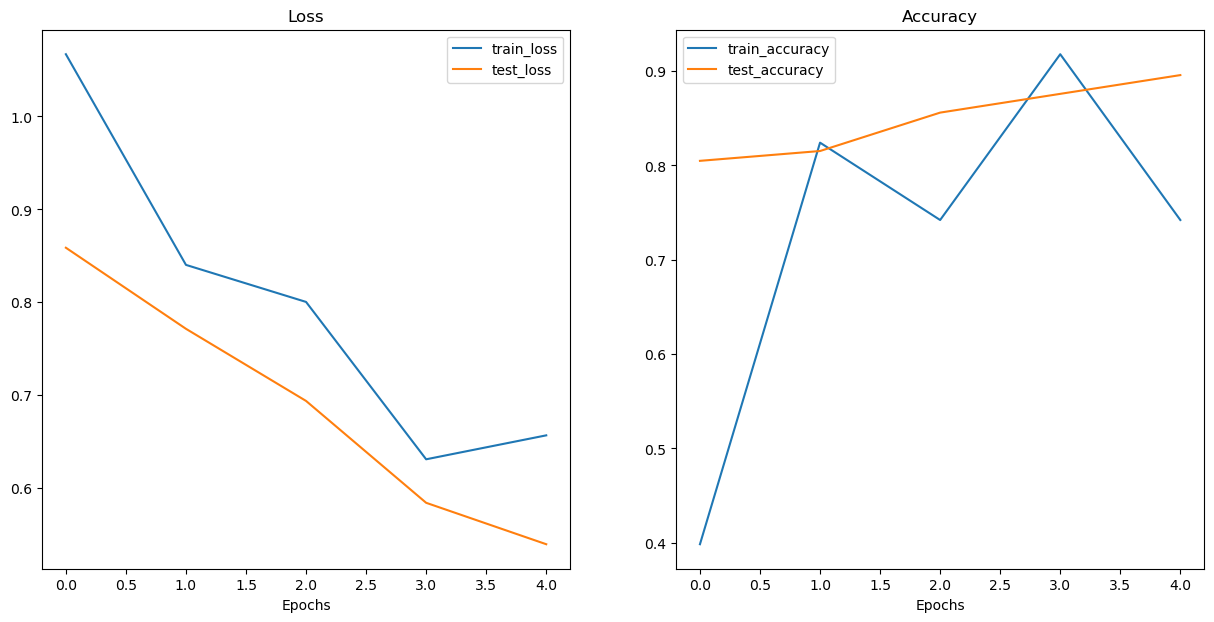

In [17]:
from helper_functions import plot_loss_curves

# Plot the loss curves
plot_loss_curves(results)

### 6. Make predicitons on images from the test set

In [18]:
%%writefile going_modular/predictions.py

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Take the necessary parameters
def pred_and_plot_image(model: torch.nn.Module, class_names: List[str], target_image_path: str,
                        image_size: Tuple[int, int] = (224, 224), transform: torchvision.transforms = None,
                        device: torch.device = device):

    # 2. Open PIL Image
    img = Image.open(target_image_path)

    # 3. Create transforms
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
        ])

    # 4. Model on target device
    model.to(device)

    # 5. model eval mode and inference context manager
    model.eval()
    with torch.inference_mode():
        # 6. Tranform the image and add a batch size dimension
        transformed_image =image_transform(img).unsqueeze(dim=0)

        # 7. Make the prediction
        target_image_pred = model(transformed_image.to(device))

    # 8. Logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    # 9. Pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    # 10. Plot image with predicitons
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Overwriting going_modular/predictions.py


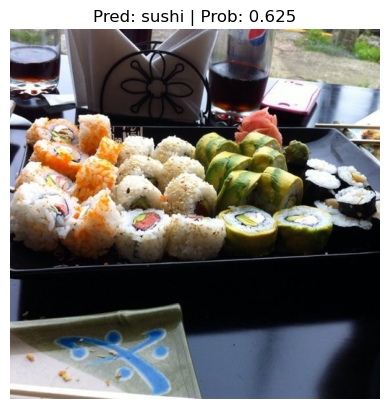

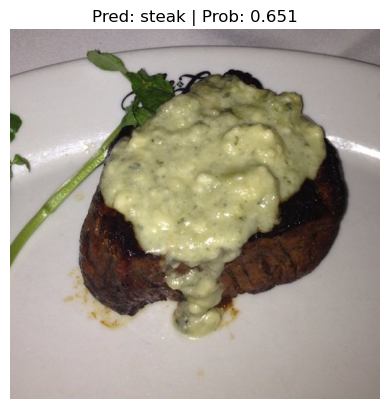

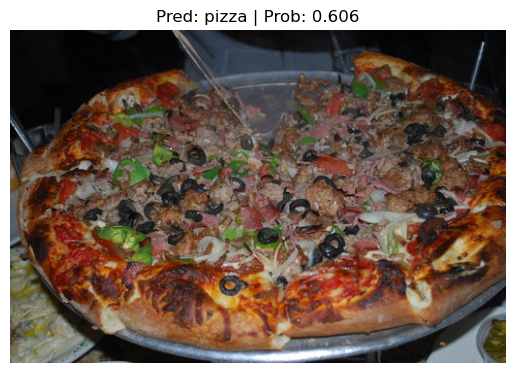

In [19]:
# Random sample a list of image paths from test set
from going_modular.predictions import pred_and_plot_image
import matplotlib.pyplot as plt
import random

num_imagees_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k = num_imagees_to_plot)

# Make preds and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model = model, class_names = class_names, target_image_path=image_path, image_size=(224, 224), transform = weights.transforms(), device = device)

#### 6.1 Making predictions on a custom image

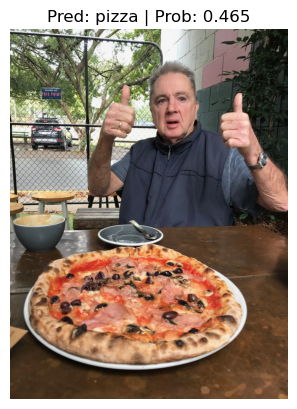

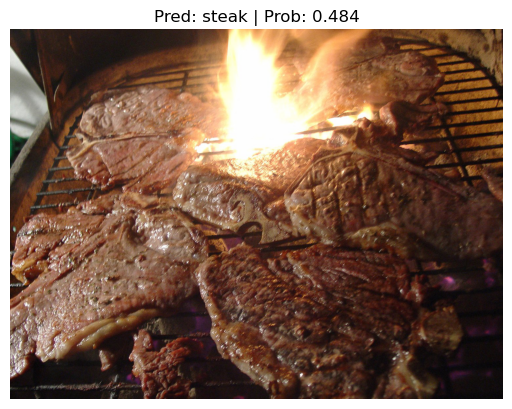

In [20]:
pred_and_plot_image(model = model, class_names = class_names, target_image_path="data/04-pizza-author.jpeg")
pred_and_plot_image(model=model, class_names = class_names, target_image_path="data/steak.jpg")